In [1]:
import unicodedata
import re
import json
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import acquire_dr
import prepare_dr
#import prepare_jag

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime
from wordcloud import WordCloud
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
df = pd.read_csv('raw_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       151 non-null    int64 
 1   repo             151 non-null    object
 2   language         143 non-null    object
 3   readme_contents  147 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.8+ KB


In [3]:
df.language.value_counts()

Swift               65
Python              38
C++                 15
C                   11
JavaScript           2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
LLVM                 1
Name: language, dtype: int64

In [4]:
df[df.language.isnull()]

,Unnamed: 0,repo,language,readme_contents
0,0,apple/llvm-project,NaN,# Apple's fork of llvm-project\n\nThis is Appl...
13,13,apple/swift-docc-render-artifact,NaN,# Swift-DocC-Render-Artifact\n\nThis repositor...
14,14,apple/swift-lmdb,NaN,# CLMDB\n\nCLMDB is a SwiftPM package wrapper ...
83,83,apple/swift-community-hosted-continuous-integr...,NaN,# Swift Community-Hosted Continuous Integratio...
123,123,apple/ml-transcript-translation-consistency-ra...,NaN,# Human Ratings of Transcription/Translation C...
139,139,apple/llvm-monorepo-root,NaN,# Disclaimer\n\nThe [llvm-monorepo-root](https...
145,145,apple/swift-protobuf-plugin,NaN,"<img src=""https://swift.org/assets/images/swif..."
149,149,apple/swift-protobuf-test-conformance,NaN,"<img src=""https://swift.org/assets/images/swif..."


#### Observations:

- There are some repositories lacking a specified language, not sure how to proceed there but there's only 8 rows missing languages
    - an idea is to infer the language based on the repository title
- llvm project does not specify language but readme states the repo contains source code for LLVM, so go with `LLVM`?
- swift docc render artifact does not specify language but the readme states that the repository holds a pre-built copy of the swift docc render repo, which is majority `javascript`
- swift imdb is `C`, not sure why the acquire function didn't pick it up
- swift community hosted continuous integration is an extension of Swift ci which allows community memberts to add platforms.
    - Seems like the most recent uploads to the swift ci site are `swift` based files.
- ml transcript translation's repo looks like is just csv files
- llvm monorepo root is a wip repository for apple's open source `Swift` project.
- swift protobuf plugin was combined under the swift-protobuf repo, which is majority `swift` programming language
- swift protobuf test conformance was combined under the swift-protobuf repo, which is majority `swift` programming language

In [5]:
df[df.index == 83].repo

83    apple/swift-community-hosted-continuous-integr...
Name: repo, dtype: object

In [6]:
nan_languages = list(df[df.language.isnull()].index)

In [7]:
for i in nan_languages:
    display(df[df.index == i])

,Unnamed: 0,repo,language,readme_contents
0,0,apple/llvm-project,NaN,# Apple's fork of llvm-project\n\nThis is Appl...


,Unnamed: 0,repo,language,readme_contents
13,13,apple/swift-docc-render-artifact,NaN,# Swift-DocC-Render-Artifact\n\nThis repositor...


,Unnamed: 0,repo,language,readme_contents
14,14,apple/swift-lmdb,NaN,# CLMDB\n\nCLMDB is a SwiftPM package wrapper ...


,Unnamed: 0,repo,language,readme_contents
83,83,apple/swift-community-hosted-continuous-integr...,NaN,# Swift Community-Hosted Continuous Integratio...


,Unnamed: 0,repo,language,readme_contents
123,123,apple/ml-transcript-translation-consistency-ra...,NaN,# Human Ratings of Transcription/Translation C...


,Unnamed: 0,repo,language,readme_contents
139,139,apple/llvm-monorepo-root,NaN,# Disclaimer\n\nThe [llvm-monorepo-root](https...


,Unnamed: 0,repo,language,readme_contents
145,145,apple/swift-protobuf-plugin,NaN,"<img src=""https://swift.org/assets/images/swif..."


,Unnamed: 0,repo,language,readme_contents
149,149,apple/swift-protobuf-test-conformance,NaN,"<img src=""https://swift.org/assets/images/swif..."


In [8]:
# let's override the languages with the observations noted
df.language.loc[0] = 'LLVM'
df.language.loc[13] = 'JavaScript'
df.language.loc[14] = 'C'
df.language.loc[83] = 'Swift'
df.language.loc[139] = 'Swift'
df.language.loc[145] = 'Swift'
df.language.loc[149] = 'Swift'

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
df.language.loc[0]

'LLVM'

In [10]:
df[df.language.isnull()]

,Unnamed: 0,repo,language,readme_contents
123,123,apple/ml-transcript-translation-consistency-ra...,NaN,# Human Ratings of Transcription/Translation C...


In [11]:
df[df.readme_contents.isnull()]

,Unnamed: 0,repo,language,readme_contents
114,114,apple/darwin-libplatform,C,NaN
135,135,apple/swift-libcxx,C++,NaN
144,144,apple/ccs-pyopendirectory,C++,NaN
150,150,apple/darwin-libpthread,C,NaN


In [12]:
df.dropna(inplace = True)
df.shape

(146, 4)

In [13]:
# let's map the less common languages to 'other' and consolidate the different c's into one
# language
df.language.value_counts()

Swift               69
Python              38
C++                 13
C                   10
JavaScript           3
LLVM                 2
Java                 2
Jupyter Notebook     2
HTML                 2
Dockerfile           1
Markdown             1
Shell                1
R                    1
Starlark             1
Name: language, dtype: int64

In [14]:
df['language']= df.language.map({'Swift': 'Swift', 'Python': 'Python', 'C++':'C', 'C': 'C',
                                 'JavaScript':'Other', 'LLVM':'Other', 'Java':'Other', 
                                 'Jupyter Notebook':'Other', 'HTML':'Other', 'Dockerfile':'Other', 
                                 'Markdown':'Other', 'Shell':'Other', 'R':'Other', 'Starlark':'Other'})

In [15]:
df.language.value_counts()

Swift     69
Python    38
C         23
Other     16
Name: language, dtype: int64

In [16]:
extra_words = ['the', 'to', 'a', 'and', 'of', 'in', 'for', 'is']

In [17]:
#extra_words

In [18]:
i = 0
for readme in df.readme_contents:
    df.readme_contents.loc[i] = prepare_dr.basic_clean(readme)
    i = i + 1

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
#i = 0

#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.tokenize(readme)
#    i = i + 1

In [20]:
#i = 0

#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.stem(readme)
#    i = i + 1

In [21]:
#i = 0

#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.lemmatize(readme)
#    i = i + 1

In [22]:
#i = 0
    
#for readme in df.readme_contents:
#    df.readme_contents.loc[i] = prepare_dr.remove_stopwords(readme)
#    i = i + 1

In [23]:
i = 0
    
for readme in df.readme_contents:
    df.readme_contents.loc[i] = prepare_dr.remove_stopwords(readme, extra_words)
    i = i + 1

In [24]:
df.readme_contents.loc[10]

'swift source compatibility suite source compatibility strong goal future swift releases aid goal community owned source compatibility test suite serves regression test changes compiler gradually increasing corpus swift source code projects added test suite periodically built latest development versions swift part swift continuous integration system https ci swift org allowing swift compiler developers understand compatibility impact changes real world swift projects current list projects href https swift org source compatibility current list projects current list projects viewed swift org adding projects swift source compatibility test suite community driven meaning open source swift project owners encouraged submit projects meet acceptance criteria inclusion test suite projects added suite serve general source compatibility tests afforded greater protection unintentional source breakage future swift releases acceptance criteria accepted swift source compatibility test suite project m

In [25]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 149
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             146 non-null    object
 1   language         146 non-null    object
 2   readme_contents  146 non-null    object
dtypes: object(3)
memory usage: 8.6+ KB


In [27]:
df.head()

,repo,language,readme_contents
0,apple/llvm-project,Other,apple fork llvm project apple fork llvm projec...
1,apple/swift-argument-parser,Swift,swift argument parser usage begin declaring ty...
2,apple/swift-docc,Swift,swift docc swift docc documentation compiler s...
3,apple/swift,C,img src https swift org assets images swift sv...
4,apple/sourcekit-lsp,Swift,sourcekit lsp sourcekit lsp implementation lan...


In [28]:
language = pd.concat([df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1)
language.columns = ['n', 'percent']
language

,n,percent
Swift,69,0.472603
Python,38,0.260274
C,23,0.157534
Other,16,0.109589


In [29]:
swift_words = ' '.join(df[df.language == 'Swift'].readme_contents).split()
python_words = ' '.join(df[df.language == 'Python'].readme_contents).split()
c_words = ' '.join(df[df.language == 'C'].readme_contents).split()
other_words = ' '.join(df[df.language == 'Other'].readme_contents).split()
all_words = ' '.join(df.readme_contents).split()

In [30]:
swift_freq = pd.Series(swift_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
c_freq = pd.Series(c_words).value_counts()
other_freq = pd.Series(other_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [31]:
word_counts = (pd.concat([all_freq, swift_freq, python_freq, c_freq, other_freq], axis = 1, sort = True)
                .set_axis(['all', 'swift', 'python', 'c', 'other'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,swift,python,c,other
"""LICENSE""",3,1,2,0,0
"""owned""",2,1,1,0,0
"""s""",2,1,1,0,0
#,2,2,0,0,0
'?',2,0,1,0,1


In [32]:
word_counts.sort_values(by = 'all', ascending = False).head(10)

,all,swift,python,c,other
swift,2282,1700,103,331,148
https,1059,623,129,188,119
com,603,406,67,72,58
apple,582,411,36,90,45
github,558,399,50,66,43
package,502,395,26,71,10
build,492,245,32,185,30
org,482,196,82,133,71
use,415,232,80,78,25
1,395,188,100,61,46


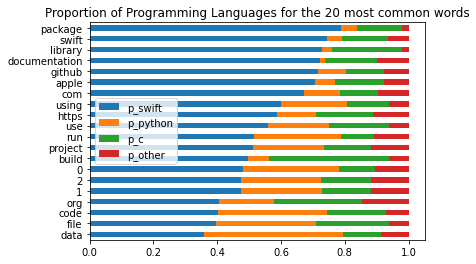

In [33]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_swift = word_counts.swift / word_counts['all'],
         p_python = word_counts.python / word_counts['all'],
         p_c = word_counts.c / word_counts['all'],
         p_other = word_counts.other / word_counts['all'])
 .sort_values(by = 'all')
 [['p_swift', 'p_python', 'p_c', 'p_other']]
 .tail(20)
 .sort_values('p_swift')
 .plot.barh(stacked=True))

plt.title('Proportion of Programming Languages for the 20 most common words');

In [34]:
top_20_swift_bigrams = (pd.Series(nltk.ngrams(swift_words, 2))
                      .value_counts()
                      .head(20))

top_20_swift_bigrams.head()

(github, com)      342
(https, github)    335
(com, apple)       276
(apple, swift)     276
(swift, org)       150
dtype: int64

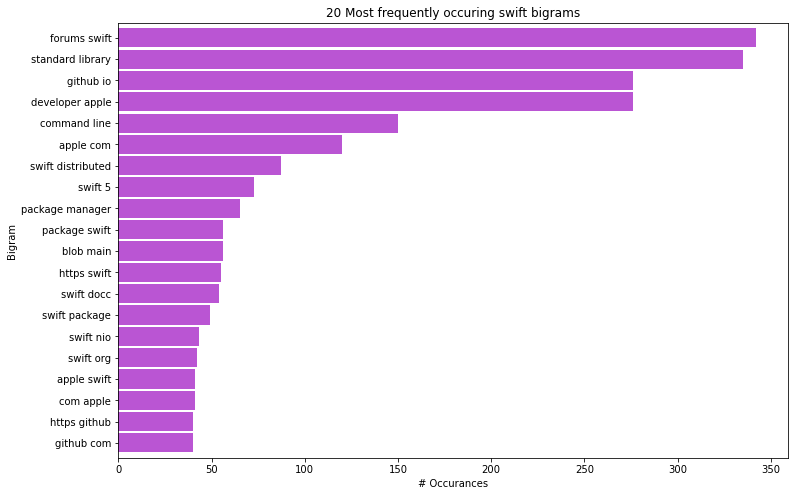

In [35]:
top_20_swift_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring swift bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_swift_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [36]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(github, com)         37
(python, tools)       32
(code, python)        31
(https, github)       31
(data, parameters)    30
dtype: int64

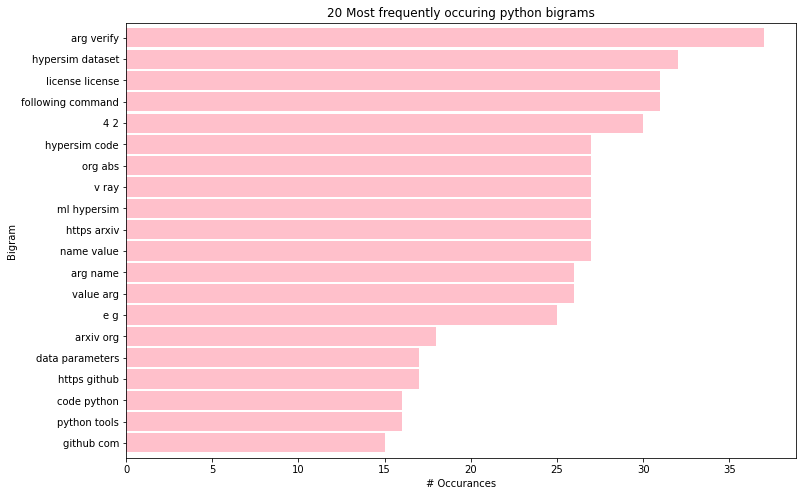

In [37]:
top_20_python_bigrams.sort_values().plot.barh(color = 'pink', width = .9, figsize = (12, 8))

plt.title('20 Most frequently occuring python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [38]:
top_20_c_bigrams = (pd.Series(nltk.ngrams(c_words, 2))
                      .value_counts()
                      .head(20))

top_20_c_bigrams.head()

(swift, org)       96
(swift, crypto)    50
(https, ci)        46
(oss, swift)       44
(job, oss)         44
dtype: int64

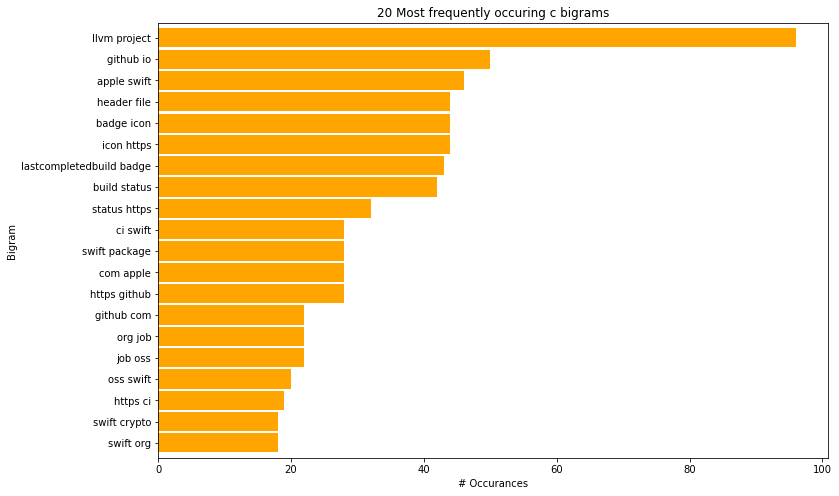

In [39]:
top_20_c_bigrams.sort_values().plot.barh(color = 'orange', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring c bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_c_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [40]:
top_20_other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))

top_20_other_bigrams.head()

(swift, org)       38
(https, github)    35
(github, com)      35
(swift, docc)      30
(https, swift)     28
dtype: int64

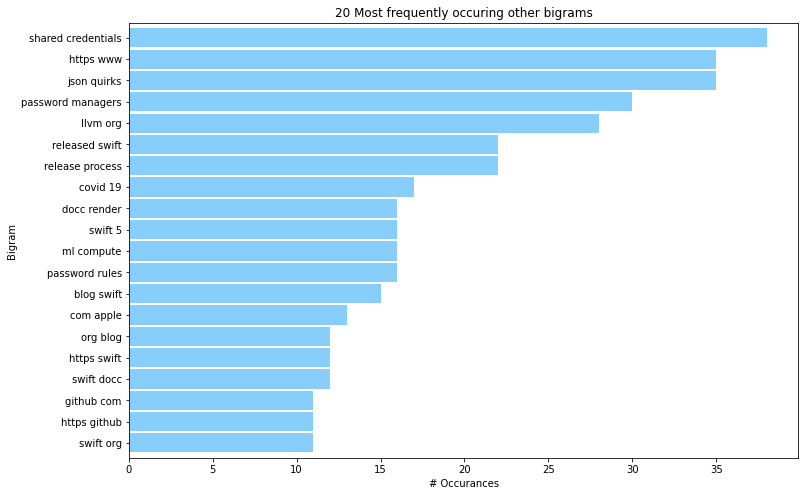

In [41]:
top_20_other_bigrams.sort_values().plot.barh(color = 'lightskyblue', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring other bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_other_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [42]:
top_20_all_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

top_20_all_bigrams.head()

(github, com)      457
(https, github)    443
(com, apple)       344
(apple, swift)     310
(swift, org)       297
dtype: int64

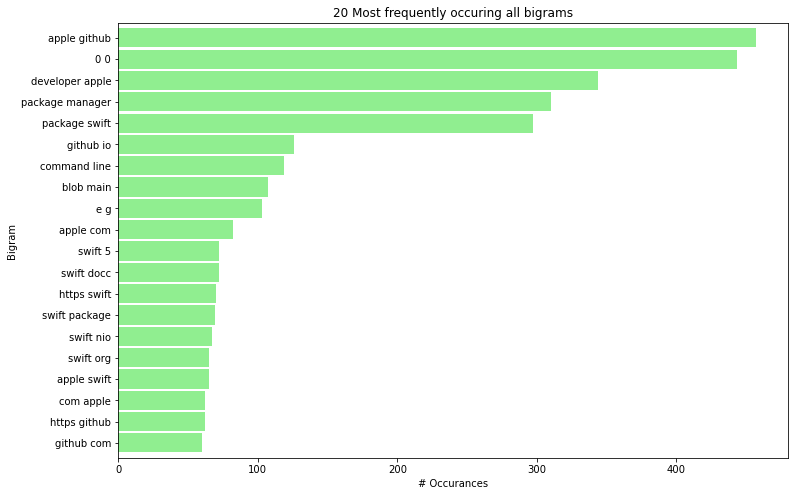

In [43]:
top_20_all_bigrams.sort_values().plot.barh(color = 'lightgreen', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring all bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_all_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


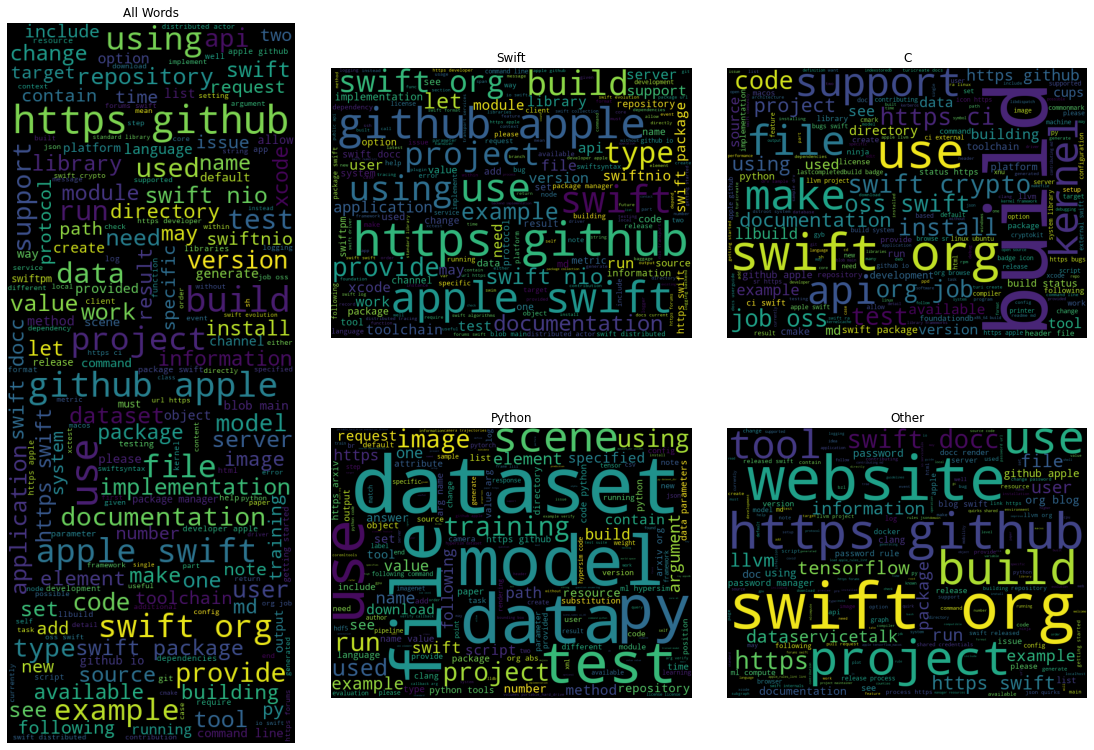

In [44]:
all_cloud = WordCloud(background_color = 'black', height = 1000, width = 400).generate(' '.join(all_words))
swift_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(swift_words))
python_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(python_words))
c_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(c_words))
other_cloud = WordCloud(background_color = 'black', height = 600, width = 800).generate(' '.join(other_words))

plt.figure(figsize = (10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([1.05, .5, .5, .5]),
      plt.axes([1.05, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(swift_cloud)
axs[2].imshow(python_cloud)
axs[3].imshow(c_cloud)
axs[4].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Swift')
axs[2].set_title('Python')
axs[3].set_title('C')
axs[4].set_title('Other')

for ax in axs: ax.axis('off')

In [45]:
# baseline
df[df['language'] == 'Swift'].language.value_counts()/sum(df.language.value_counts())

Swift    0.472603
Name: language, dtype: float64

In [46]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [47]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 77.59%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          11      1       0      0
Python      1      1      25      1
Swift       6     11       5     54
---
              precision    recall  f1-score   support

           C       0.92      0.61      0.73        18
       Other       0.00      0.00      0.00        13
      Python       0.89      0.83      0.86        30
       Swift       0.71      0.98      0.82        55

    accuracy                           0.78       116
   macro avg       0.63      0.61      0.60       116
weighted avg       0.71      0.78      0.73       116



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dtc = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [49]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 70.69%
---
Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          9      0       3      0
Python     2      8      23      5
Swift      7      5       4     50
---
              precision    recall  f1-score   support

           C       0.75      0.50      0.60        18
       Other       0.00      0.00      0.00        13
      Python       0.61      0.77      0.68        30
       Swift       0.76      0.91      0.83        55

    accuracy                           0.71       116
   macro avg       0.53      0.54      0.53       116
weighted avg       0.63      0.71      0.66       116



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
for i in range(3,11):
    dtc = DecisionTreeClassifier(max_depth = i).fit(X_train, y_train)

    train['predicted'] = dtc.predict(X_train)
    test['predicted'] = dtc.predict(X_test)
    
    print('Decision Tree Depth =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Decision Tree Depth =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')

Decision Tree Depth = 3
Accuracy: 75.86%
---
Train Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          9      0       0      0
Python     3      8      29      5
Swift      6      5       1     50
---
              precision    recall  f1-score   support

           C       1.00      0.50      0.67        18
       Other       0.00      0.00      0.00        13
      Python       0.64      0.97      0.77        30
       Swift       0.81      0.91      0.85        55

    accuracy                           0.76       116
   macro avg       0.61      0.59      0.57       116
weighted avg       0.70      0.76      0.71       116

Decision Tree Depth = 3
Accuracy: 70.00%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
Python     4      2       7      0
Swift      1      1       1     14
---
              precision    recall  f1-score   support

           C       0.00      0.00     

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

Decision Tree Depth = 5
Accuracy: 87.93%
---
Train Data - Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          15      0       0      0
Other       0      8       0      1
Python      0      0      25      0
Swift       3      5       5     54
---
              precision    recall  f1-score   support

           C       1.00      0.83      0.91        18
       Other       0.89      0.62      0.73        13
      Python       1.00      0.83      0.91        30
       Swift       0.81      0.98      0.89        55

    accuracy                           0.88       116
   macro avg       0.92      0.82      0.86       116
weighted avg       0.90      0.88      0.88       116

Decision Tree Depth = 5
Accuracy: 60.00%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          0      0       0      1
Other      1      1       0      0
Python     2      1       4      0
Swift      2      1  

/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123).fit(X_train, y_train)

train['predicted'] = rf.predict(X_train)
test['predicted'] = rf.predict(X_test)

In [52]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 64.66%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
Python      2      0      21      1
Swift      16     13       9     54
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00        18
       Other       0.00      0.00      0.00        13
      Python       0.88      0.70      0.78        30
       Swift       0.59      0.98      0.73        55

    accuracy                           0.65       116
   macro avg       0.37      0.42      0.38       116
weighted avg       0.50      0.65      0.55       116



/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_contents)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train, y_train)

train['predicted'] = dtc.predict(X_train)
test['predicted'] = dtc.predict(X_test)

In [54]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 91.38%
---
Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          16      0       0      2
Other       1     11       1      1
Python      1      1      27      0
Swift       0      1       2     52
---
              precision    recall  f1-score   support

           C       0.89      0.89      0.89        18
       Other       0.79      0.85      0.81        13
      Python       0.93      0.90      0.92        30
       Swift       0.95      0.95      0.95        55

    accuracy                           0.91       116
   macro avg       0.89      0.90      0.89       116
weighted avg       0.92      0.91      0.91       116



In [55]:
for i in range(3,11):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)

    train['predicted'] = dtc.predict(X_train)
    test['predicted'] = dtc.predict(X_test)
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
    print('---')
    print('Train Data - Confusion Matrix')
    print(pd.crosstab(train.predicted, train.actual))
    print('---')
    print(classification_report(train.actual, train.predicted))
    
    print('Value of K =', i)
    print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
    print('---')
    print('Test Data - Confusion Matrix')
    print(pd.crosstab(test.predicted, test.actual))
    print('---')
    print(classification_report(test.actual, test.predicted))
    print('------------------------------------------------------')

Value of K = 3
Accuracy: 91.38%
---
Train Data - Confusion Matrix
actual      C  Other  Python  Swift
predicted                          
C          16      0       0      2
Other       1     11       1      1
Python      1      1      27      0
Swift       0      1       2     52
---
              precision    recall  f1-score   support

           C       0.89      0.89      0.89        18
       Other       0.79      0.85      0.81        13
      Python       0.93      0.90      0.92        30
       Swift       0.95      0.95      0.95        55

    accuracy                           0.91       116
   macro avg       0.89      0.90      0.89       116
weighted avg       0.92      0.91      0.91       116

Value of K = 3
Accuracy: 93.33%
---
Test Data - Confusion Matrix
actual     C  Other  Python  Swift
predicted                         
C          3      0       0      0
Other      1      3       0      0
Python     0      0       8      0
Swift      1      0       0     14
---


Swift      1      0       0     14
---
              precision    recall  f1-score   support

           C       1.00      0.60      0.75         5
       Other       0.75      1.00      0.86         3
      Python       1.00      1.00      1.00         8
       Swift       0.93      1.00      0.97        14

    accuracy                           0.93        30
   macro avg       0.92      0.90      0.89        30
weighted avg       0.94      0.93      0.93        30

------------------------------------------------------
